<a href="https://colab.research.google.com/github/mariaofsweden/grupp27/blob/main/Kopia_av_inlamning2_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detta är ett urval med funktioner från aima search.py. Ni måste inte förstå varje bit, men kolla gärna närmre på sökalgoritmerna och hur grafproblemet skapats. **I uppgiften kommer ingen definition behöva ändras, endast vad som skapas i slutet.**

I denna notebook ärver klassen GraphProblem från abstrakta klassen Problem. Man skapar inte objekt av abstrakta klasser, de ärvs bara av andra klasser. Både Graph och Problem använder sig av Node-objekt. 

In [1]:
"""
The way to use this code is to subclass Problem to create a class of problems,
then create problem instances and solve them with calls to the various search
functions.
"""

import numpy as np
import random
import sys

from collections import deque
from queue import PriorityQueue


class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError


# ______________________________________________________________________________


class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state. Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node. Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        # We use the hash value of the state
        # stored in the node instead of the node
        # object itself to quickly search a node
        # with the same state in a Hash Table
        return hash(self.state)


# ______________________________________________________________________________


def UndirectedGraph(graph_dict=None):
    """Build a Graph where every edge (including future ones) goes both ways."""
    return Graph(graph_dict=graph_dict, directed=False)


class Graph:
    """A graph connects nodes (vertices) by edges (links). Each edge can also
    have a length associated with it. The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C. You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added. You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B. 'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)

Här skapas en definition på ett grafproblem som motsvarar en karta, varje nod innehåller namn och position. Dess heuristiska funktion är definierat som avståndet från noden till målet.

In [2]:
#  GRAPHPROBLEM DEFINITION

def distance(a, b):
    """The distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return np.hypot((xA - xB), (yA - yB))

class GraphProblem(Problem):
    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        super().__init__(initial, goal)
        self.graph = graph

    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or np.inf)

    def find_min_edge(self):
        """Find minimum value of edges."""
        m = np.inf
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)

        return m

    def h(self, node):
        """h function is straight-line distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(distance(locs[node], locs[self.goal]))

            return int(distance(locs[node.state], locs[self.goal]))
        else:
            return np.inf

Definitioner för ett litet urval av sökalgoritmer finns här. För att få en en snabb jämförelse har även en rad som skriver ut en stjärna lagts till i varje algoritm.

In [3]:
# ______________________________________________________________________________
# Uninformed Search algorithms

def depth_first_graph_search(problem):
    """
    Search the deepest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Does not get trapped by loops.
    If two paths reach a state, only use the first one.
    """
    frontier = [(Node(problem.initial))]  # Stack

    explored = set()
    while frontier:
        print('*', end='')
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and child not in frontier)
    return None


def breadth_first_graph_search(problem):
    """
    Note that this function can be implemented in a
    single line as below:
    return graph_search(problem, FIFOQueue())
    """
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = deque([node])
    explored = set()
    while frontier:
        node = frontier.popleft()
        explored.add(node.state)
        for child in node.expand(problem):
            print('*', end='')
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    return child
                frontier.append(child)
    return None

# ______________________________________________________________________________
# Informed (Heuristic) Search

def recursive_best_first_search(problem, h=None):
    h = memoize(h or problem.h, 'h')

    def RBFS(problem, node, flimit):
        print('*', end='')
        if problem.goal_test(node.state):
            return node, 0  # (The second value is immaterial)
        successors = node.expand(problem)
        if len(successors) == 0:
            return None, np.inf
        for s in successors:
            s.f = max(s.path_cost + h(s), node.f)
        while True:
            # Order by lowest f value
            successors.sort(key=lambda x: x.f)
            best = successors[0]
            if best.f > flimit:
                return None, best.f
            if len(successors) > 1:
                alternative = successors[1].f
            else:
                alternative = np.inf
            result, best.f = RBFS(problem, best, min(flimit, alternative))
            if result is not None:
                return result, best.f

    node = Node(problem.initial)
    node.f = h(node)
    result, bestf = RBFS(problem, node, np.inf)
    return result

#help function
def memoize(fn, slot=None, maxsize=32):
    """Memoize fn: make it remember the computed value for any argument list.
    If slot is specified, store result in that slot of first argument.
    If slot is false, use lru_cache for caching the values."""
    if slot:
        def memoized_fn(obj, *args):
            if hasattr(obj, slot):
                return getattr(obj, slot)
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    return memoized_fn

Vi skapar en graf som kan användas i ett grafproblem, i deta fall används några kopplade städer i Rumänien
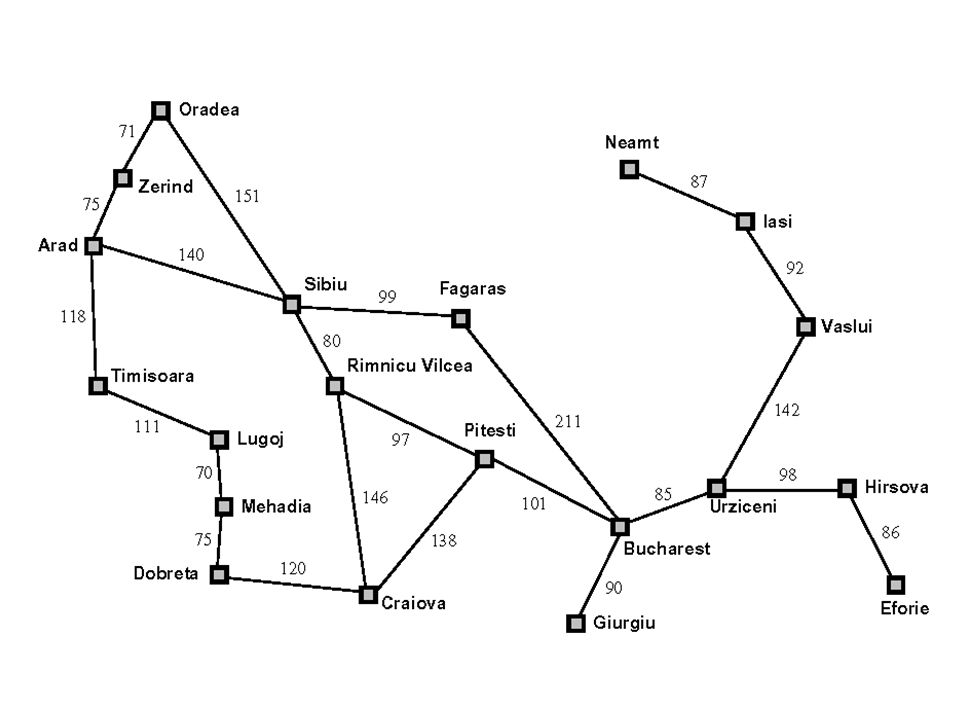

In [4]:
""" 
Simplified road map of Romania
"""
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))
romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))


Vi skapar ett grafproblem och jämför olika sökmetoder. Du kan ändra start och mål för problemet

In [5]:
romania_problem=GraphProblem('Arad', 'Bucharest', romania_map)

In [6]:
depth = depth_first_graph_search(romania_problem)
print()
print(depth.solution())
print("With cost:", depth.path_cost)

********
['Timisoara', 'Lugoj', 'Mehadia', 'Drobeta', 'Craiova', 'Pitesti', 'Bucharest']
With cost: 733


In [7]:
breadth = breadth_first_graph_search(romania_problem)
print()
print(breadth.solution())
print("With cost:", breadth.path_cost)

***************
['Sibiu', 'Fagaras', 'Bucharest']
With cost: 450


In [8]:
best = recursive_best_first_search(romania_problem, romania_problem.h)
print()
print(best.solution())
print("With cost:", best.path_cost)

******
['Sibiu', 'Rimnicu', 'Pitesti', 'Bucharest']
With cost: 418


# Nytt avsnitt